In [1]:
import wandb
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from scipy.stats import ttest_rel

import json


float_formatter = "{:.2f}".format
np.set_printoptions(formatter={'float_kind':float_formatter})

_ = sns.set(style="darkgrid", palette="colorblind")

In [3]:
def get_last_avg_return(entity, project, experiments, window=100, frequency=1000):
    api = wandb.Api()
    runs = api.runs(entity + "/" + project)
    dfs = []
    df = pd.DataFrame(columns=["Experiment", "Seed", "Avg. Episodic Return"])
    for run in runs:
        _, experiment, seed, _ = run.name.split("__")
        if experiment in experiments:
            history = run.scan_history(keys=["charts/episodic_return", "global_step"])
            df_ = pd.DataFrame(history)
            df_["Avg. Episodic Return"] = df_["charts/episodic_return"].rolling(window, min_periods=1, center=True, closed="both").mean()
            decimated = np.arange(0, 2990000 + 1, frequency).reshape(-1, 1)
            d = cdist(df_["global_step"].to_numpy().reshape(-1, 1), decimated)
            idx = np.argmin(d, 0)
            df_ = df_.loc[idx]
            df_["Experiment"] = experiment
            df_["seed"] = seed
            df_["Global Step"] = frequency * round(df_["global_step"] / frequency)
            df = pd.concat(
                [
                    df,
                    pd.DataFrame(
                        [
                            {
                                "Experiment": experiment,
                                "Seed": seed,
                                "Avg. Episodic Return": df_["Avg. Episodic Return"].iloc[-1]
                            }
                        ]
                    )
                ]
            )
            dfs.append(df_)
    dfg = df.sort_values(["Experiment","Seed"]).groupby("Experiment")
    means = dfg.mean()["Avg. Episodic Return"].to_numpy()
    pvals = np.zeros((len(experiments), len(experiments)))
    for i, g  in enumerate(experiments):
        for j, h  in enumerate(experiments):
            if i == j:
                pvals[i, j] = means[i]
            else:
                pvals[i, j] = ttest_rel(dfg.get_group(g)["Avg. Episodic Return"], dfg.get_group(h)["Avg. Episodic Return"]).pvalue
    return pvals, pd.concat(dfs, ignore_index=True)

In [4]:
from scipy import integrate

def auc_dict(df, env, result_dict = {}):
    
    grouped_df = df.groupby(['Experiment', 'seed'])

    for (experiment, seed), group in grouped_df:
        x = group['global_step'].tolist()
        y = group['charts/episodic_return'].tolist()
        
        # Calculate the area under the curve for this group
        auc = integrate.trapz(y, x)
        
        # Add the calculated auc to the corresponding Experiment in the result_dict
        if experiment in result_dict:
            if env in result_dict[experiment]:
                result_dict[experiment][env].append(auc)
            else:
                result_dict[experiment].update({env: [auc]})
        else:
            result_dict[experiment] = {env: [auc]}

    return result_dict

		no-ReLU Adv.		all-actions		VSOP		no-spectral		no-Thompson		
no-ReLU Adv.		570.24		0.00		0.00		0.00		0.00		
all-actions		0.00		116.04		0.00		0.00		0.00		
VSOP		0.00		0.00		4713.88		0.00		0.08		
no-spectral		0.00		0.00		0.00		2378.69		0.02		
no-Thompson		0.00		0.00		0.08		0.02		3864.16		


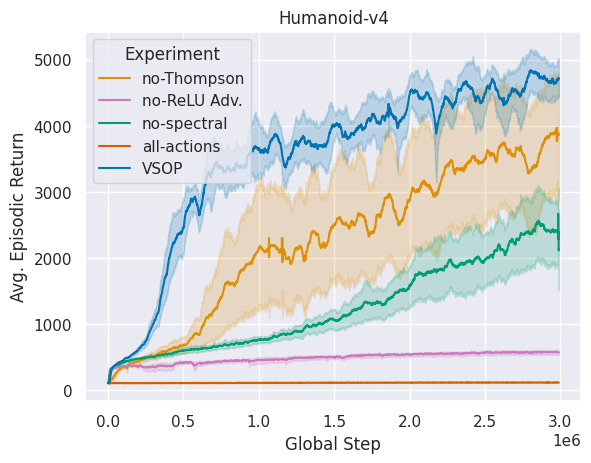

In [16]:
entity = "vsop"
project = "Humanoid-v4"
mapping = {
    "vsop-190": "VSOP",
    "vsop-9g5": "no-Thompson",
    "vsop-8a8": "no-spectral",
    "a3c-8ea": "no-ReLU Adv.",
    "rmpg-31e": "all-actions",
}
experiments = list(mapping.keys())
experiments.sort()
pvals, df = get_last_avg_return(
    entity,
    project,
    experiments,
    window=100,
    frequency=1000,
)
for i in range(len(experiments)):
    if i == 0:
        row = "\t\t"
        for j in range(len(experiments)):
            row += f"{mapping[experiments[j]]}\t\t"
        print(row)
    row = f"{mapping[experiments[i]]}\t\t"
    for j in range(len(experiments)):
        row += f"{pvals[i, j]:.2f}\t\t"
    print(row)
for k, v in mapping.items():
    df.loc[df["Experiment"] == k, "Experiment"] = v
_ = sns.lineplot(
    df,
    x="Global Step",
    y="Avg. Episodic Return",
    hue="Experiment",
    palette={
        "VSOP": "C0",
        "no-Thompson": "C1",
        "no-spectral": "C2",
        "all-actions": "C3",
        "no-ReLU Adv.": "C4",
    },
    errorbar=("ci", 95),
)
_ = plt.title(f"{project}")

In [17]:
ad = auc_dict(df, project)
# ad = auc_dict(df, project, ad)

		no-ReLU Adv.		all-actions		VSOP		no-Thompson		no-spectral		
no-ReLU Adv.		655.25		0.58		0.00		0.02		0.00		
all-actions		0.58		548.37		0.00		0.00		0.00		
VSOP		0.00		0.00		2907.75		0.04		0.74		
no-Thompson		0.02		0.00		0.04		2051.20		0.05		
no-spectral		0.00		0.00		0.74		0.05		2807.33		


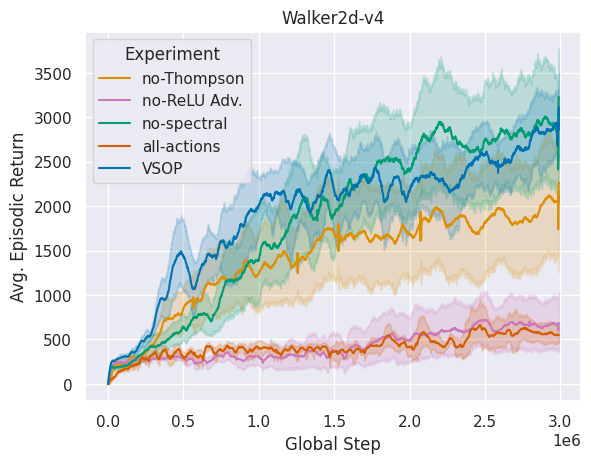

In [18]:
project = "Walker2d-v4"
mapping = {
    "vsop-32r": "VSOP",
    "vsop-3ck": "no-Thompson",
    "vsop-810": "no-spectral",
    "rmpg-1sn": "all-actions",
    "a3c-4dm": "no-ReLU Adv.",
}
experiments = list(mapping.keys())
experiments.sort()
pvals, df = get_last_avg_return(
    entity,
    project,
    experiments,
    window=100,
    frequency=1000,
)
for i in range(len(experiments)):
    if i == 0:
        row = "\t\t"
        for j in range(len(experiments)):
            row += f"{mapping[experiments[j]]}\t\t"
        print(row)
    row = f"{mapping[experiments[i]]}\t\t"
    for j in range(len(experiments)):
        row += f"{pvals[i, j]:.2f}\t\t"
    print(row)
for k, v in mapping.items():
    df.loc[df["Experiment"] == k, "Experiment"] = v
_ = sns.lineplot(
    df,
    x="Global Step",
    y="Avg. Episodic Return",
    hue="Experiment",
    palette={
        "VSOP": "C0",
        "no-Thompson": "C1",
        "no-spectral": "C2",
        "all-actions": "C3",
        "no-ReLU Adv.": "C4",
    },
    errorbar=("ci", 95),
)
_ = plt.title(f"{project}")

In [19]:
with open("mujoco_mechanism_efficiency.json", "w") as outfile:
    json.dump(ad, outfile)

In [20]:
"Write it!"
ad = auc_dict(df, project, ad)

		no-ReLU Adv.		all-actions		VSOP		no-spectral		no-Thompson		
no-ReLU Adv.		280.70		0.12		0.00		0.01		0.00		
all-actions		0.12		1056.17		0.00		0.04		0.00		
VSOP		0.00		0.00		4307.54		0.00		0.83		
no-spectral		0.01		0.04		0.00		2351.36		0.00		
no-Thompson		0.00		0.00		0.83		0.00		4418.92		


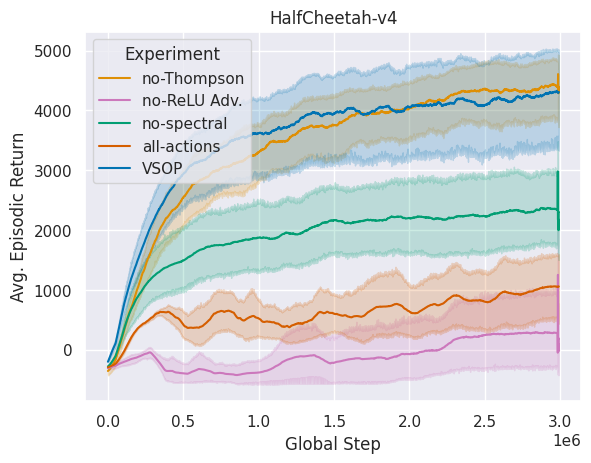

In [21]:
entity = "vsop"
project = "HalfCheetah-v4"
mapping = {
    "vsop-1ta": "VSOP",
    "vsop-3gp": "no-Thompson",
    "vsop-28v": "no-spectral",
    "rmpg-26y": "all-actions",
    "a3c-5nm": "no-ReLU Adv.",
}
experiments = list(mapping.keys())
experiments.sort()
pvals, df = get_last_avg_return(
    entity,
    project,
    experiments,
    window=100,
    frequency=1000,
)
for i in range(len(experiments)):
    if i == 0:
        row = "\t\t"
        for j in range(len(experiments)):
            row += f"{mapping[experiments[j]]}\t\t"
        print(row)
    row = f"{mapping[experiments[i]]}\t\t"
    for j in range(len(experiments)):
        row += f"{pvals[i, j]:.2f}\t\t"
    print(row)
for k, v in mapping.items():
    df.loc[df["Experiment"] == k, "Experiment"] = v
_ = sns.lineplot(
    df,
    x="Global Step",
    y="Avg. Episodic Return",
    hue="Experiment",
    palette={
        "VSOP": "C0",
        "no-Thompson": "C1",
        "no-spectral": "C2",
        "all-actions": "C3",
        "no-ReLU Adv.": "C4",
    },
    errorbar=("ci", 95),
)
_ = plt.title(f"{project}")

In [22]:
ad = auc_dict(df, project, ad)

		no-ReLU Adv.		all-actions		no-spectral		no-Thompson		VSOP		
no-ReLU Adv.		1038.35		0.00		0.01		0.15		0.00		
all-actions		0.00		470.72		0.00		0.00		0.00		
no-spectral		0.01		0.00		1599.34		0.30		0.27		
no-Thompson		0.15		0.00		0.30		1362.29		0.05		
VSOP		0.00		0.00		0.27		0.05		1826.80		


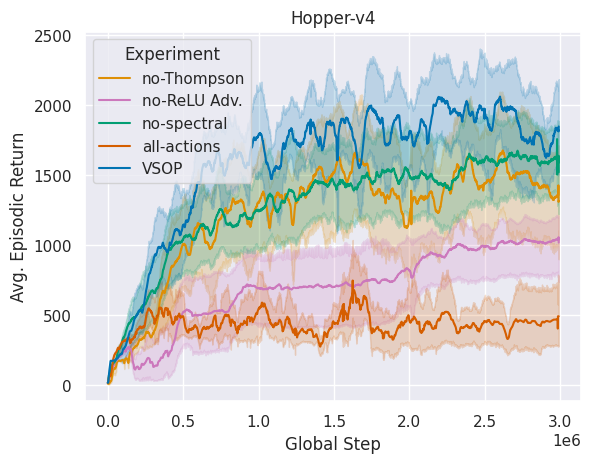

In [23]:
project = "Hopper-v4"
mapping = {
    "vsop-7dy": "VSOP",
    "vsop-2v6": "no-Thompson",
    "vsop-11y": "no-spectral",
    "rmpg-4yc": "all-actions",
    "a3c-9sv": "no-ReLU Adv.",
}
experiments = list(mapping.keys())
experiments.sort()
pvals, df = get_last_avg_return(
    entity,
    project,
    experiments,
    window=100,
    frequency=1000,
)
for i in range(len(experiments)):
    if i == 0:
        row = "\t\t"
        for j in range(len(experiments)):
            row += f"{mapping[experiments[j]]}\t\t"
        print(row)
    row = f"{mapping[experiments[i]]}\t\t"
    for j in range(len(experiments)):
        row += f"{pvals[i, j]:.2f}\t\t"
    print(row)
for k, v in mapping.items():
    df.loc[df["Experiment"] == k, "Experiment"] = v
_ = sns.lineplot(
    df,
    x="Global Step",
    y="Avg. Episodic Return",
    hue="Experiment",
    palette={
        "VSOP": "C0",
        "no-Thompson": "C1",
        "no-spectral": "C2",
        "all-actions": "C3",
        "no-ReLU Adv.": "C4",
    },
    errorbar=("ci", 95),
)
_ = plt.title(f"{project}")

In [24]:
ad = auc_dict(df, project, ad)

		no-ReLU Adv.		all-actions		VSOP		no-spectral		no-Thompson		
no-ReLU Adv.		-50.09		0.00		0.03		0.00		0.00		
all-actions		0.00		-79.70		0.00		0.20		0.00		
VSOP		0.03		0.00		-60.06		0.00		0.70		
no-spectral		0.00		0.20		0.00		-86.89		0.00		
no-Thompson		0.00		0.00		0.70		0.00		-58.53		


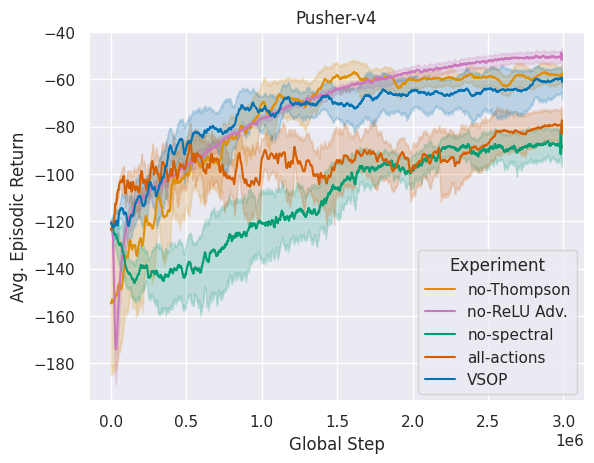

In [26]:
project = "Pusher-v4"
mapping = {
    "vsop-13w": "VSOP",
    "vsop-5lh": "no-Thompson",
    "vsop-55b": "no-spectral",
    "rmpg-9e4": "all-actions",
    "a3c-3b5": "no-ReLU Adv.",
}
experiments = list(mapping.keys())
experiments.sort()
pvals, df = get_last_avg_return(
    entity,
    project,
    experiments,
    window=100,
    frequency=1000,
)
for i in range(len(experiments)):
    if i == 0:
        row = "\t\t"
        for j in range(len(experiments)):
            row += f"{mapping[experiments[j]]}\t\t"
        print(row)
    row = f"{mapping[experiments[i]]}\t\t"
    for j in range(len(experiments)):
        row += f"{pvals[i, j]:.2f}\t\t"
    print(row)
for k, v in mapping.items():
    df.loc[df["Experiment"] == k, "Experiment"] = v
_ = sns.lineplot(
    df,
    x="Global Step",
    y="Avg. Episodic Return",
    hue="Experiment",
    palette={
        "VSOP": "C0",
        "no-Thompson": "C1",
        "no-spectral": "C2",
        "all-actions": "C3",
        "no-ReLU Adv.": "C4",
    },
    errorbar=("ci", 95),
)
_ = plt.title(f"{project}")

In [27]:
ad = auc_dict(df, project, ad)

		no-ReLU Adv.		all-actions		VSOP		no-spectral		no-Thompson		
no-ReLU Adv.		290.91		0.00		0.00		0.01		0.00		
all-actions		0.00		872.18		0.00		0.95		0.00		
VSOP		0.00		0.00		3898.22		0.00		0.56		
no-spectral		0.01		0.95		0.00		879.09		0.00		
no-Thompson		0.00		0.00		0.56		0.00		3667.13		


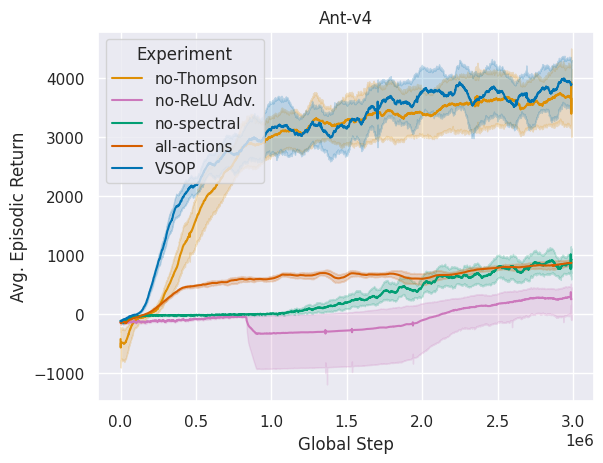

In [28]:
project = "Ant-v4"
mapping = {
    "vsop-4e2": "VSOP",
    "vsop-6yc": "no-Thompson",
    "vsop-4my": "no-spectral",
    "rmpg-7dp": "all-actions",
    "a3c-8qw": "no-ReLU Adv.",
}
experiments = list(mapping.keys())
experiments.sort()
pvals, df = get_last_avg_return(
    entity,
    project,
    experiments,
    window=100,
    frequency=1000,
)
for i in range(len(experiments)):
    if i == 0:
        row = "\t\t"
        for j in range(len(experiments)):
            row += f"{mapping[experiments[j]]}\t\t"
        print(row)
    row = f"{mapping[experiments[i]]}\t\t"
    for j in range(len(experiments)):
        row += f"{pvals[i, j]:.2f}\t\t"
    print(row)
for k, v in mapping.items():
    df.loc[df["Experiment"] == k, "Experiment"] = v
_ = sns.lineplot(
    df,
    x="Global Step",
    y="Avg. Episodic Return",
    hue="Experiment",
    palette={
        "VSOP": "C0",
        "no-Thompson": "C1",
        "no-spectral": "C2",
        "all-actions": "C3",
        "no-ReLU Adv.": "C4",
    },
    errorbar=("ci", 95),
)
_ = plt.title(f"{project}")

In [29]:
ad = auc_dict(df, project, ad)

		no-ReLU Adv.		all-actions		no-Thompson		no-spectral		VSOP		
no-ReLU Adv.		34.67		0.00		0.00		0.00		0.00		
all-actions		0.00		7551.31		0.38		0.84		0.97		
no-Thompson		0.00		0.38		8188.96		0.26		0.43		
no-spectral		0.00		0.84		0.26		7695.99		0.84		
VSOP		0.00		0.97		0.43		0.84		7517.62		


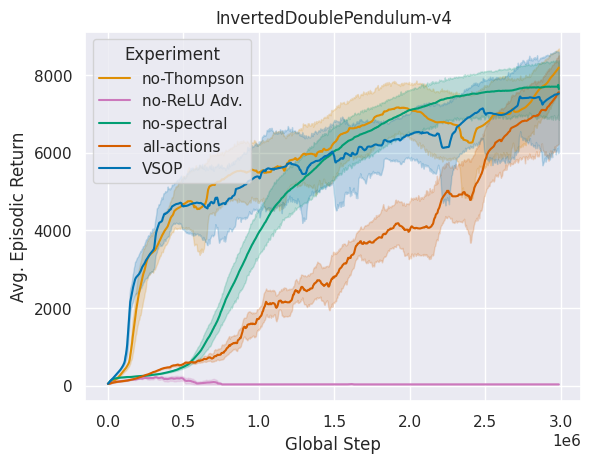

In [6]:
entity = "vsop"
project = "InvertedDoublePendulum-v4"
mapping = {
    "vsop-9kl": "VSOP",
    "vsop-3k1": "no-Thompson",
    "vsop-6ar": "no-spectral",
    "rmpg-7c3": "all-actions",
    "a3c-1aw": "no-ReLU Adv.",
}
experiments = list(mapping.keys())
experiments.sort()
pvals, df = get_last_avg_return(
    entity,
    project,
    experiments,
    window=1000,
    frequency=4000,
)
for i in range(len(experiments)):
    if i == 0:
        row = "\t\t"
        for j in range(len(experiments)):
            row += f"{mapping[experiments[j]]}\t\t"
        print(row)
    row = f"{mapping[experiments[i]]}\t\t"
    for j in range(len(experiments)):
        row += f"{pvals[i, j]:.2f}\t\t"
    print(row)
for k, v in mapping.items():
    df.loc[df["Experiment"] == k, "Experiment"] = v
_ = sns.lineplot(
    df,
    x="Global Step",
    y="Avg. Episodic Return",
    hue="Experiment",
    palette={
        "VSOP": "C0",
        "no-Thompson": "C1",
        "no-spectral": "C2",
        "all-actions": "C3",
        "no-ReLU Adv.": "C4",
    },
    errorbar=("ci", 95),
)
_ = plt.title(f"{project}")

In [7]:
ad = auc_dict(df, project, ad)

		no-ReLU Adv.		all-actions		no-Thompson		VSOP		no-spectral		
no-ReLU Adv.		94442.74		0.00		0.00		0.00		0.00		
all-actions		0.00		38246.63		0.00		0.00		0.00		
no-Thompson		0.00		0.00		146718.52		0.11		0.06		
VSOP		0.00		0.00		0.11		155168.63		0.62		
no-spectral		0.00		0.00		0.06		0.62		157974.61		


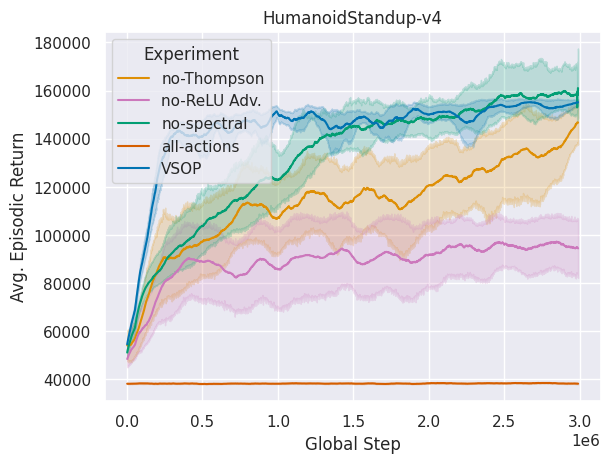

In [8]:
project = "HumanoidStandup-v4"
mapping = {
    "vsop-5c1": "VSOP",
    "vsop-4ki": "no-Thompson",
    "vsop-9wz": "no-spectral",
    "rmpg-7hv": "all-actions",
    "a3c-2ks": "no-ReLU Adv.",
}
experiments = list(mapping.keys())
experiments.sort()
pvals, df = get_last_avg_return(
    entity,
    project,
    experiments,
    window=100,
    frequency=1000,
)
for i in range(len(experiments)):
    if i == 0:
        row = "\t\t"
        for j in range(len(experiments)):
            row += f"{mapping[experiments[j]]}\t\t"
        print(row)
    row = f"{mapping[experiments[i]]}\t\t"
    for j in range(len(experiments)):
        row += f"{pvals[i, j]:.2f}\t\t"
    print(row)
for k, v in mapping.items():
    df.loc[df["Experiment"] == k, "Experiment"] = v
_ = sns.lineplot(
    df,
    x="Global Step",
    y="Avg. Episodic Return",
    hue="Experiment",
    palette={
        "VSOP": "C0",
        "no-Thompson": "C1",
        "no-spectral": "C2",
        "all-actions": "C3",
        "no-ReLU Adv.": "C4",
    },
    errorbar=("ci", 95),
)
_ = plt.title(f"{project}")

In [9]:
ad = auc_dict(df, project, ad)

		no-ReLU Adv.		all-actions		VSOP		no-spectral		no-Thompson		
no-ReLU Adv.		-10.29		0.00		0.00		0.05		0.00		
all-actions		0.00		-27.86		0.01		0.00		0.00		
VSOP		0.00		0.01		-15.05		0.00		0.54		
no-spectral		0.05		0.00		0.00		-11.66		0.01		
no-Thompson		0.00		0.00		0.54		0.01		-15.57		


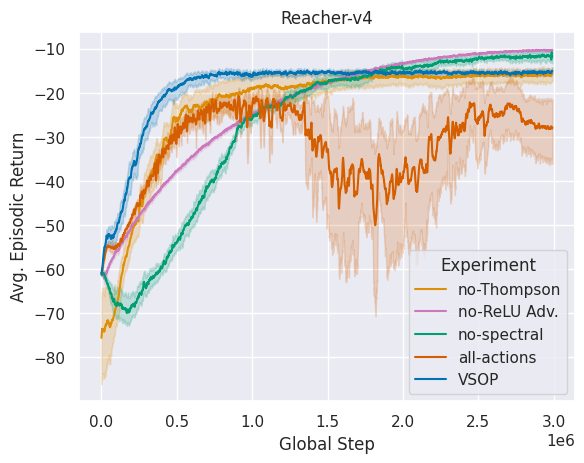

In [10]:
project = "Reacher-v4"
mapping = {
    "vsop-382": "VSOP",
    "vsop-9na": "no-Thompson",
    "vsop-6qc": "no-spectral",
    "rmpg-9v7": "all-actions",
    "a3c-5or": "no-ReLU Adv.",
}
experiments = list(mapping.keys())
experiments.sort()
pvals, df = get_last_avg_return(
    entity,
    project,
    experiments,
    window=100,
    frequency=1000,
)
for i in range(len(experiments)):
    if i == 0:
        row = "\t\t"
        for j in range(len(experiments)):
            row += f"{mapping[experiments[j]]}\t\t"
        print(row)
    row = f"{mapping[experiments[i]]}\t\t"
    for j in range(len(experiments)):
        row += f"{pvals[i, j]:.2f}\t\t"
    print(row)
for k, v in mapping.items():
    df.loc[df["Experiment"] == k, "Experiment"] = v
_ = sns.lineplot(
    df,
    x="Global Step",
    y="Avg. Episodic Return",
    hue="Experiment",
    palette={
        "VSOP": "C0",
        "no-Thompson": "C1",
        "no-spectral": "C2",
        "all-actions": "C3",
        "no-ReLU Adv.": "C4",
    },
    errorbar=("ci", 95),
)
_ = plt.title(f"{project}")

In [11]:
ad = auc_dict(df, project, ad)

		no-ReLU Adv.		all-actions		VSOP		no-Thompson		no-spectral		
no-ReLU Adv.		11.32		0.00		0.00		0.00		0.00		
all-actions		0.00		43.02		0.09		0.02		0.00		
VSOP		0.00		0.09		58.23		0.93		0.00		
no-Thompson		0.00		0.02		0.93		58.77		0.00		
no-spectral		0.00		0.00		0.00		0.00		107.78		


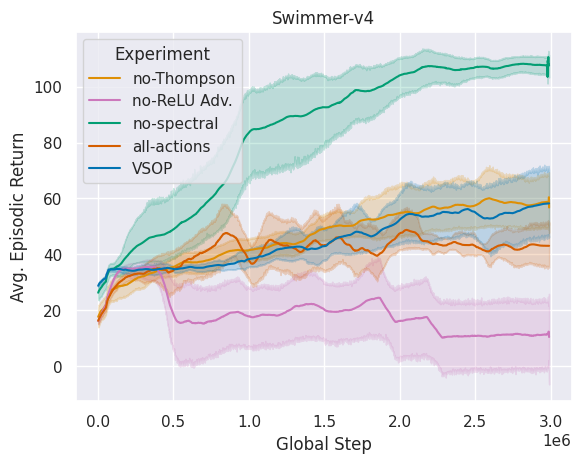

In [12]:
project = "Swimmer-v4"
mapping = {
    "vsop-1om": "VSOP",
    "vsop-6at": "no-Thompson",
    "vsop-6xe": "no-spectral",
    "rmpg-3lj": "all-actions",
    "a3c-4yw": "no-ReLU Adv.",
}
experiments = list(mapping.keys())
experiments.sort()
pvals, df = get_last_avg_return(
    entity,
    project,
    experiments,
    window=100,
    frequency=1000,
)
for i in range(len(experiments)):
    if i == 0:
        row = "\t\t"
        for j in range(len(experiments)):
            row += f"{mapping[experiments[j]]}\t\t"
        print(row)
    row = f"{mapping[experiments[i]]}\t\t"
    for j in range(len(experiments)):
        row += f"{pvals[i, j]:.2f}\t\t"
    print(row)
for k, v in mapping.items():
    df.loc[df["Experiment"] == k, "Experiment"] = v
_ = sns.lineplot(
    df,
    x="Global Step",
    y="Avg. Episodic Return",
    hue="Experiment",
    palette={
        "VSOP": "C0",
        "no-Thompson": "C1",
        "no-spectral": "C2",
        "all-actions": "C3",
        "no-ReLU Adv.": "C4",
    },
    errorbar=("ci", 95),
)
_ = plt.title(f"{project}")

In [13]:
ad = auc_dict(df, project, ad)

In [30]:
entity = "a-jesson"
ppo_projects = {
    "Ant-v4": "ppo-977",
    "Reacher-v4": "ppo-2pj",
    "InvertedDoublePendulum-v4": "ppo-7r5",
    "Pusher-v4": "ppo-804",
    "Humanoid-v4": "ppo-2jo",
    "HumanoidStandup-v4": "ppo-3ox",
    "Swimmer-v4": "ppo-6p6",
    "Hopper-v4": "ppo-624",
    "HalfCheetah-v4": "ppo-f9y",
    "Walker2d-v4": "ppo-5kc",
}
ad_ppo = {}
for project, experiment in ppo_projects.items():
    print(project, experiment)
    _, df = pvals, df = get_last_avg_return(
        entity, 
        project, 
        [experiment],
        window=100,
        frequency=1000,
    )
    ad_ppo = auc_dict(df, project, ad_ppo)

Ant-v4 ppo-977
Reacher-v4 ppo-2pj
InvertedDoublePendulum-v4 ppo-7r5
Pusher-v4 ppo-804
Humanoid-v4 ppo-2jo
HumanoidStandup-v4 ppo-3ox
Swimmer-v4 ppo-6p6
Hopper-v4 ppo-624
HalfCheetah-v4 ppo-f9y
Walker2d-v4 ppo-5kc


In [32]:
ad["PPO"] = {}
for k, v, in ad_ppo.items():
    ad["PPO"].update(v)

In [ ]:
with open("mujoco_mechanism_efficiency.json", "w") as outfile:
    json.dump(ad, outfile)